# File and libraries

In [6]:
import pandas as pd
import numpy as np


file_tag = "Google Merch Store 2024-2025"


# DSLabs functions

In [1]:
%run "scripts/dslabs_functions.py"


# Data functions

In [2]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [3]:
test_data=True
# test_data=False


train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

target='Sessions'

# Prepare the training and testing data from dataframes with features and target
# trnX = train.drop(columns=[target])
# trnY = train[target]
# tstX = test.drop(columns=[target])
# tstY = test[target]


from numpy import arange

# Ensure no data leakage
assert not set(train.index).intersection(set(test.index)), "Data leakage detected: Train and test sets overlap."


# # Prepare the training and testing data using the time index as the feature
trnX = arange(len(train)).reshape(-1, 1)
trnY = train[target].to_numpy()
tstX = arange(len(train), len(train+test)).reshape(-1, 1)
tstY = test[target].to_numpy()

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 2024-01-14 to 2024-12-09
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Seven-day active users           331 non-null    float64
 1   28-day active users              331 non-null    float64
 2   Events per session               331 non-null    float64
 3   Item view events                 331 non-null    float64
 4   Add to baskets                   331 non-null    float64
 5   Checkouts                        331 non-null    float64
 6   E-commerce purchases             331 non-null    float64
 7   Average purchase revenue         331 non-null    float64
 8   Purchase revenue                 331 non-null    float64
 9   First time purchasers            331 non-null    float64
 10  Average session duration         331 non-null    float64
 11  ARPU                             331 non-null    float64
 12  ARP

## Simple Average

## Simple Average evaluate

In [4]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

In [5]:

import pandas as pd

# Fit the Model
model = SimpleAvgRegressor()
model.fit(pd.Series(trnY))

# Predict the training and testing data
prd_trn = pd.Series(model.predict(pd.Series(trnY)), index=train.index)
prd_tst = pd.Series(model.predict(pd.Series(tstY)), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Simple Average Forecasting Evaluation")
savefig(f"images/{file_tag}_simple_average_evaluation.png")

c:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\ProgramData\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\ProgramData\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 'file_tag' is not defined

## Simple Average Forecasting

<Axes: xlabel='Date', ylabel='Sessions'>

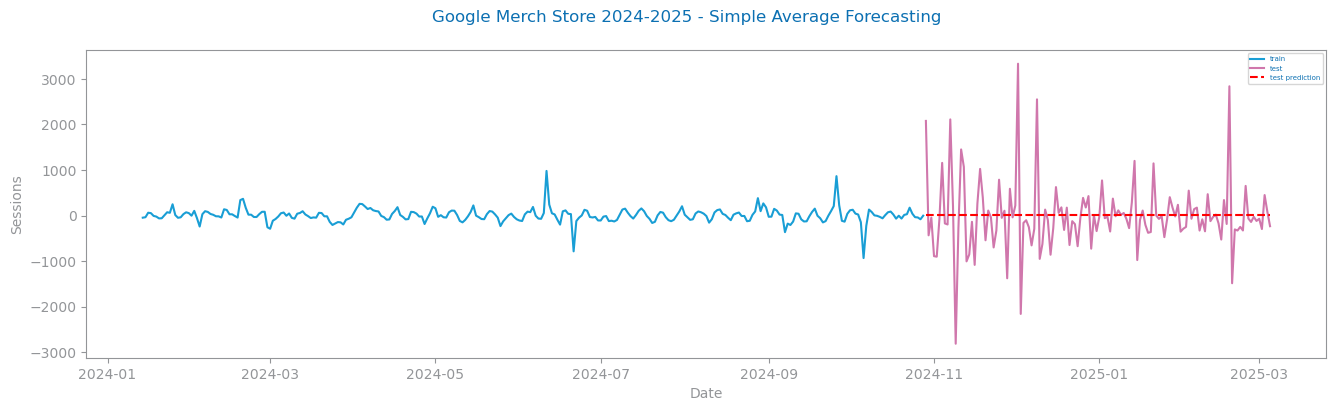

In [ ]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Simple Average Forecasting",
    xlabel='Date',
    ylabel=target,
)

# Persistence Model

## Persistence Evaluate

In [ ]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

### Persistence Optimist

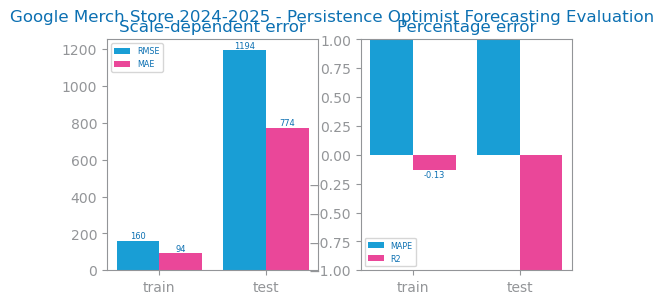

In [ ]:

# Fit the Model
model = PersistenceOptimistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn = Series(model.predict(trnY), index=train.index)
prd_tst = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist Forecasting Evaluation")
savefig(f"images/{file_tag}_persitence_optimist_evaluation.png")

### Persistence Optimist Plot

<Axes: xlabel='Date', ylabel='Sessions'>

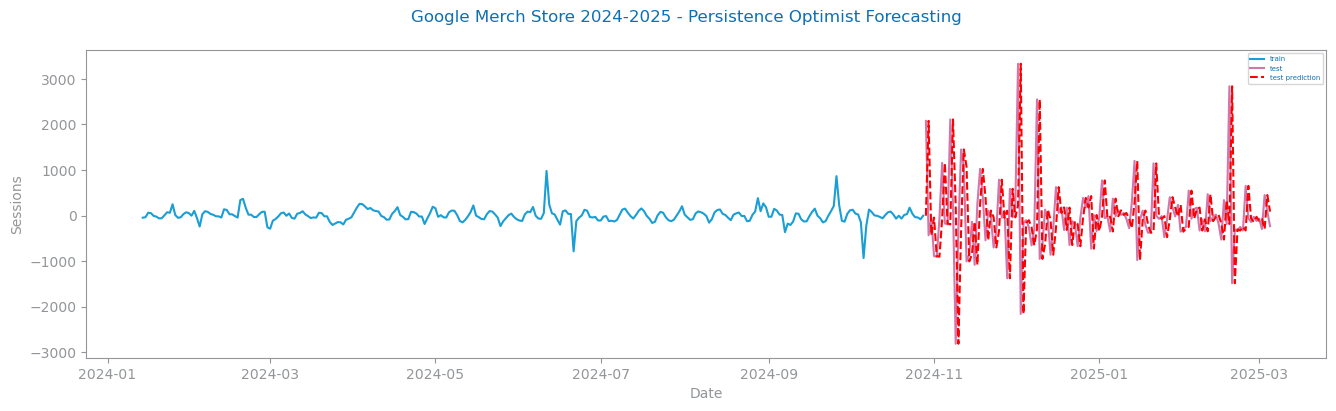

In [ ]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Persistence Optimist Forecasting",
    xlabel='Date',
    ylabel=target,
)

### Persistence Realist

In [ ]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

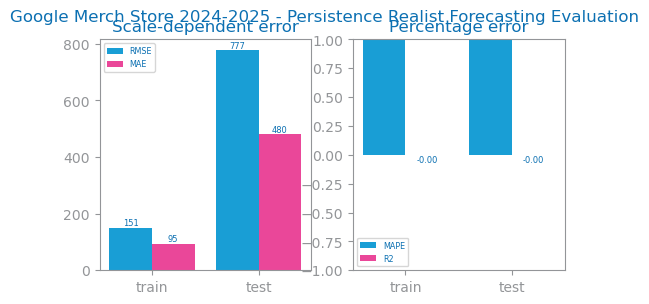

In [ ]:

# Fit the Model
model = PersistenceRealistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn = Series(model.predict(trnY), index=train.index)
prd_tst = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Persistence Realist Forecasting Evaluation")
savefig(f"images/{file_tag}_persitence_realist_evaluation.png")

<Axes: xlabel='Date', ylabel='Sessions'>

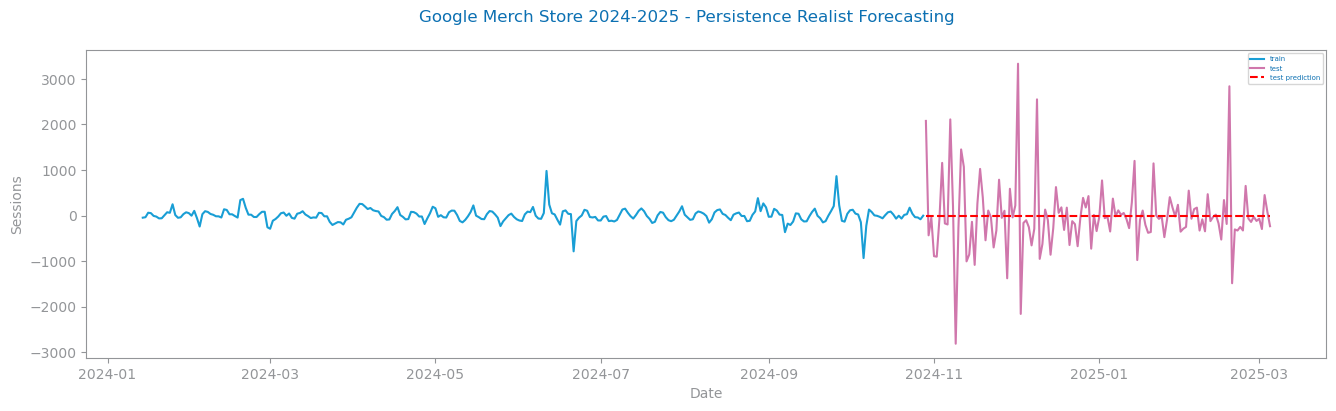

In [ ]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Persistence Realist Forecasting",
    xlabel='Date',
    ylabel=target,
)

# Exponential Smoothing

### Exponential Smoothing Study

In [ ]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing Study - ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Exponential Smoothing best with alpha=0 -> R2=-1.638151701710555e-05


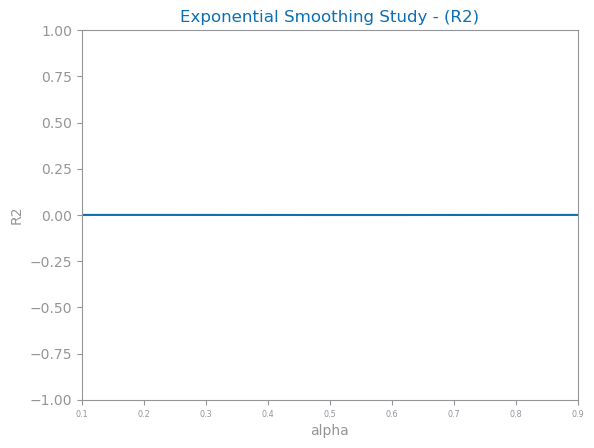

In [ ]:
from matplotlib.pyplot import savefig

measure: str = "R2"


best_model, best_params = exponential_smoothing_study(trnY, tstY, measure=measure)
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_study.png")

### Exponential Study Evaluate

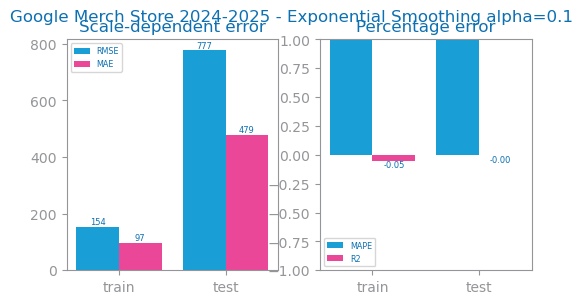

In [ ]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(trnY) - 1)
prd_tst = best_model.forecast(steps=len(tstY))

plot_forecasting_eval(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_eval.png")

### Exponential Smoothing Forecast Plot

<Axes: xlabel='Date', ylabel='Sessions'>

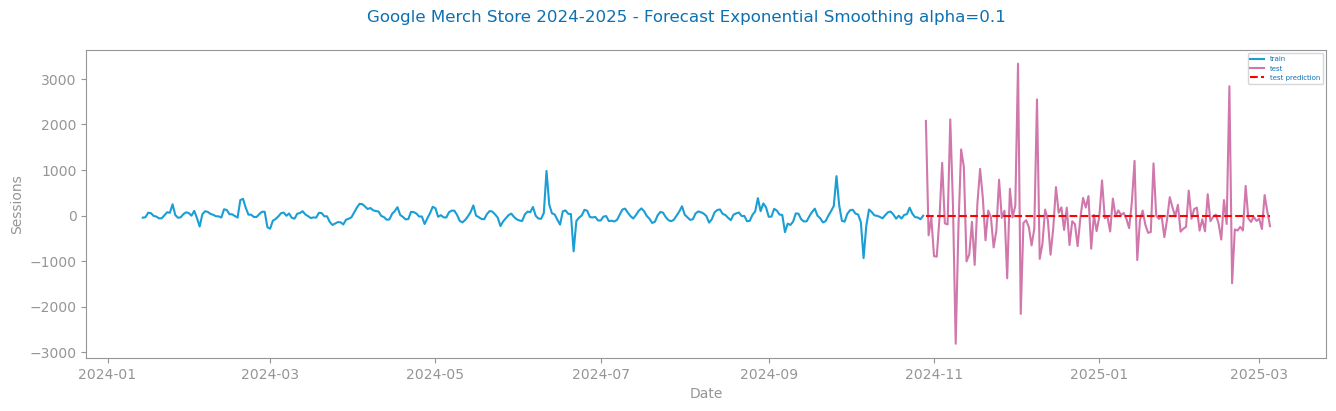

In [ ]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Forecast Exponential Smoothing alpha={params[0]}",
    xlabel='Date',
    ylabel=target,
)

# Rolling Mean

In [ ]:
from numpy import mean
from sklearn.base import RegressorMixin



class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: Series = Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series

### Rolling Mean Study

NOT WORKING

In [ ]:
def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    # win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    win_size = (12, 24, 48, 96, 192, 384, 768)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)
        prd_tst = prd_tst[:len(test)]  # Ensure the predicted series has the same length as the test series

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

# best_model, best_params = rolling_mean_study(trnY, tstY)
# savefig(f"images/{file_tag}_rollingmean_{measure}_study.png")

### Rolling Mean Evaluation

In [ ]:
# params = best_params["params"]
# prd_trn = best_model.predict(start=0, end=len(trnY) - 1)
# prd_tst = best_model.forecast(steps=len(tstY))

# plot_forecasting_eval(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean alpha={params[0]}")
# savefig(f"images/{file_tag}_rolling_mean_{measure}_eval.png")

### Rolling Mean Plot Forecast

In [ ]:
# plot_forecasting_series(
#     train[target],
#     test[target],
#     prd_tst,
#     title=f"{file_tag} - Forecast Rolling Mean alpha={params[0]}",
#     xlabel='Date',
#     ylabel=target,
# )

# Linear Regression

## Linear Regression Evaluate

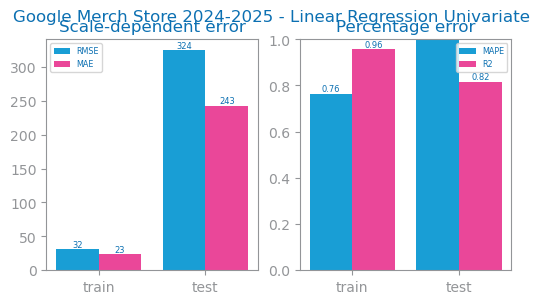

In [ ]:
from pandas import Series
from dslabs_functions import plot_forecasting_eval
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to create lagged features
def create_lagged_features(df, target, lags=3):
    df_copy = df.copy()
    for lag in range(1, lags + 1):
        df_copy[f'{target}_lag{lag}'] = df_copy[target].shift(lag)
    return df_copy

# Apply lagged features to the training data
train_lagged = create_lagged_features(train, target, lags=1)
test_lagged = create_lagged_features(test, target, lags=1)

# Drop rows with NaN values created by lagging
train_lagged.dropna(inplace=True)
test_lagged.dropna(inplace=True)

# Prepare the training and testing data
trnX_lagged = train_lagged.drop(columns=[target])
trnY_lagged = train_lagged[target]
tstX_lagged = test_lagged.drop(columns=[target])
tstY_lagged = test_lagged[target]

# Fit the linear regression model
model = LinearRegression()
model.fit(trnX_lagged, trnY_lagged)

# Predict the training and testing data
prd_trn = Series(model.predict(trnX_lagged), index=train_lagged.index)
prd_tst = Series(model.predict(tstX_lagged), index=test_lagged.index)

# Plot the forecasting evaluation
plot_forecasting_eval(trnY_lagged, tstY_lagged, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Univariate")
savefig(f"images/{file_tag}_linear_regression_univariate.png")

## Linear Regression Plot

<Axes: xlabel='Date', ylabel='Sessions'>

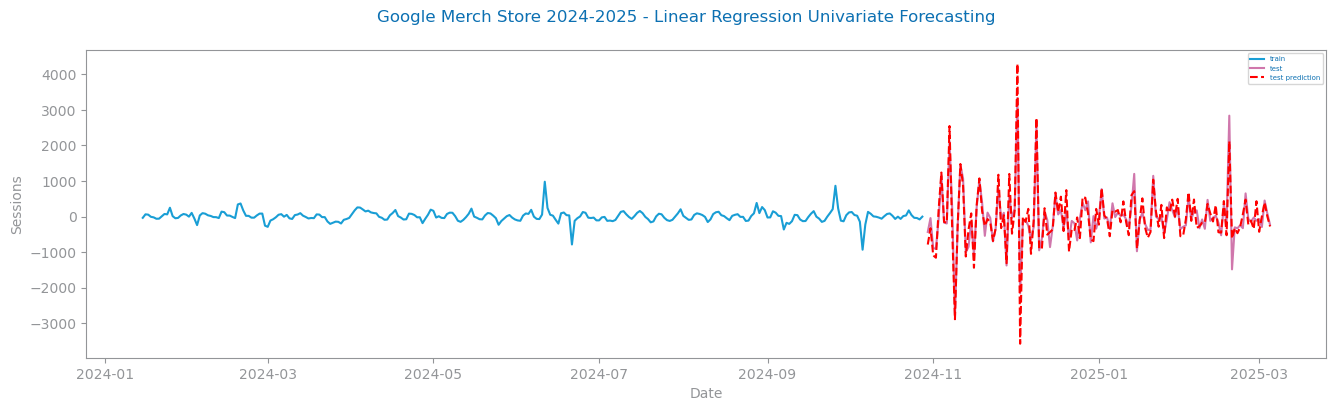

In [ ]:
plot_forecasting_series(
    train_lagged[target],
    test_lagged[target],
    prd_tst,
    title=f"{file_tag} - Linear Regression Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)

# ARIMA

## ARIMA Model Creation

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

predictor = ARIMA(trnY, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                  289
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1815.437
Date:                Mon, 17 Mar 2025   AIC                           3642.873
Time:                        22:58:14   BIC                           3664.851
Sample:                    01-14-2024   HQIC                          3651.680
                         - 10-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4310      0.042    -10.161      0.000      -0.514      -0.348
ar.L2          0.2870      0.062      4.604      0.000       0.165       0.409
ar.L3         -0.1235      0.067     -1.842      0.0

## ARIMA Model Plot Diagnostics

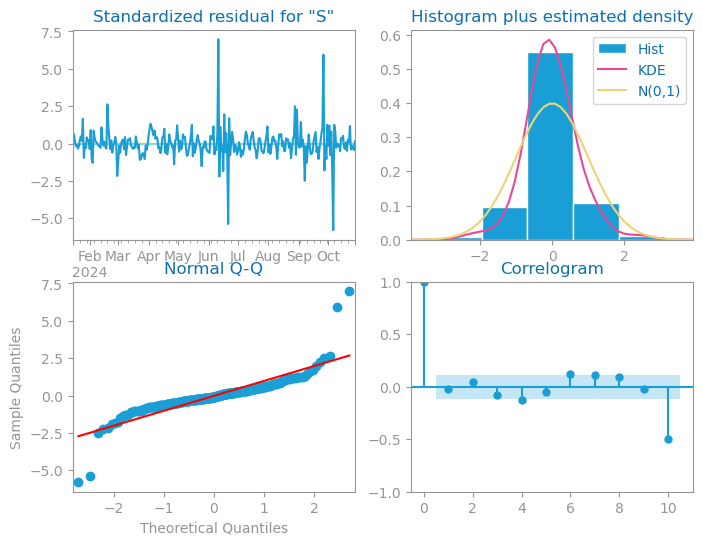

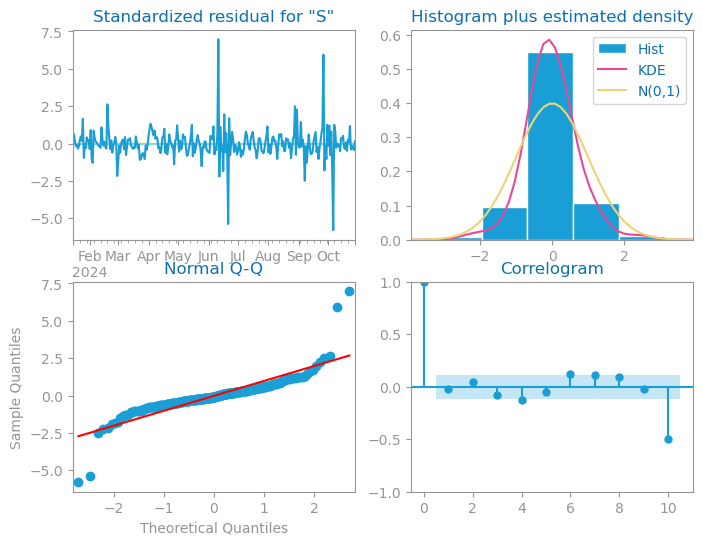

In [ ]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Model Study

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

ARIMA best results achieved with (p,d,q)=(3, 0, 3) ==> measure=0.19


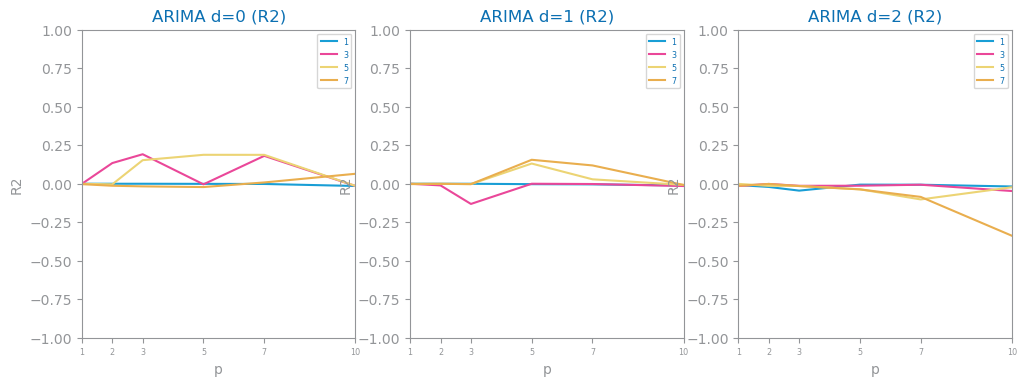

In [ ]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params


from matplotlib.pyplot import savefig

best_model, best_params = arima_study(trnY, trnY, measure=measure)
savefig(f"images/{file_tag}_arima_{measure}_study.png")

## ARIMA Evaluate

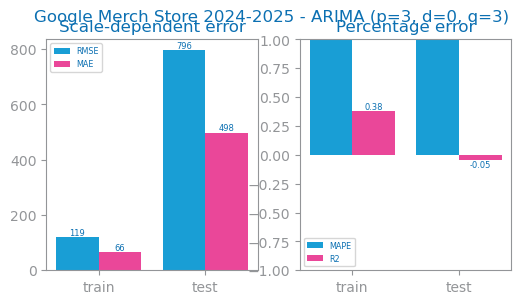

In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_eval.png")

## ARIMA Plot

<Axes: xlabel='Date', ylabel='Sessions'>

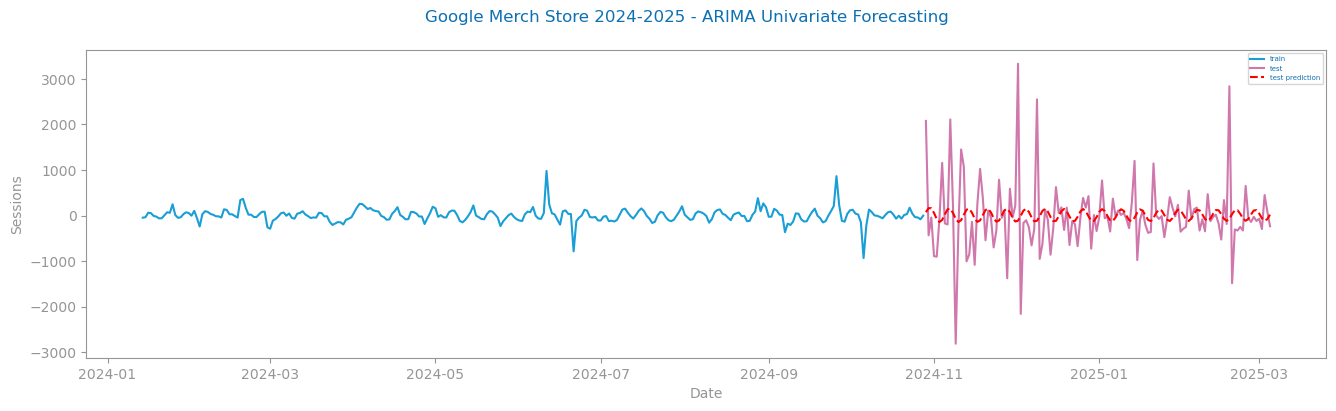

In [ ]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)